### **Projet de IQ01** : Frameworks et programmation quantique

#### Code d'implémentation en informatique classique et quantique d'une instance du TSP

Source : https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html

In [1]:
# Imports
import time
from carbontracker.tracker import CarbonTracker
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qiskit.circuit.library import n_local
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Tsp
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
from qiskit_optimization.optimizers import SPSA
from qiskit_optimization.utils import algorithm_globals
from qiskit_optimization.converters import QuadraticProgramToQubo
from itertools import permutations

#### Fonctions utilitaires pour l'affichage de graphes

In [2]:
# Fonction d'affichage du TSP sous forme de graphe complet, non orienté, pondéré
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [3]:
# Fonction d'affichage de résolution du TSP sous forme de cycle hamiltonien orienté pondéré
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

#### Déclaration d'une instance du TSP à 5 villes

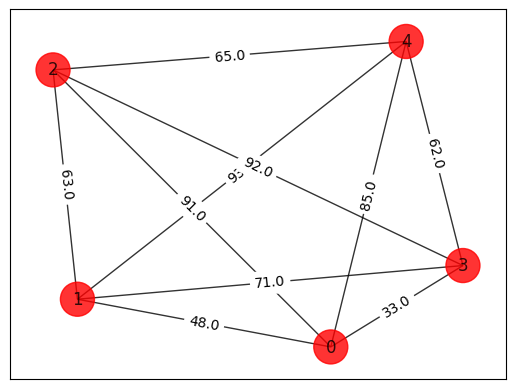

In [4]:
n = 5
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)


#### Résolution classique par force brute
Méthode de résolution qui consiste à tester toutes les combinaisons possibles pour trouver la meilleure.


In [5]:
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N))) # Liste de toutes les (n-1)! permutations possibles
    last_best_distance = 1e10 # Définition d'une distance large (10^10) que l'on cherche a optimiser 
    
    for i in a : # Pour chaque permutation
        distance = 0
        pre_j = 0 # Sommet de départ
        for j in i: # Pour chaque sommet
            distance = distance + w[j, pre_j] # Ajout du coût de l'arête traversée à la variable distance
            pre_j = j # Sommet actuel
    
        distance = distance + w[pre_j, 0] # Ajout du coût de retour à la ville de départ
        order = (0,) + i # Ajout de la ville de départ au cycle
        
        if distance < last_best_distance : # Si la distance est inférieure à la dernière meilleure distance
            best_order = order # Le cycle devient le meilleur cycle
            last_best_distance = distance # La distance devient la meilleure dernière distance
            print("order = " + str(order) + " Distance = " + str(distance)) 
            # Affichage des cycles qui battent la meilleure dernière distance
    return last_best_distance, best_order

In [6]:
best_distance, best_order = brute_force_tsp(adj_matrix, n)
# La matrice adj_matrix contient les distances entre les sommets i et j

print("Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance))

order = (0, 1, 2, 3, 4) Distance = 350.0
order = (0, 1, 2, 4, 3) Distance = 271.0
Best order from brute force = (0, 1, 2, 4, 3) with total distance = 271.0


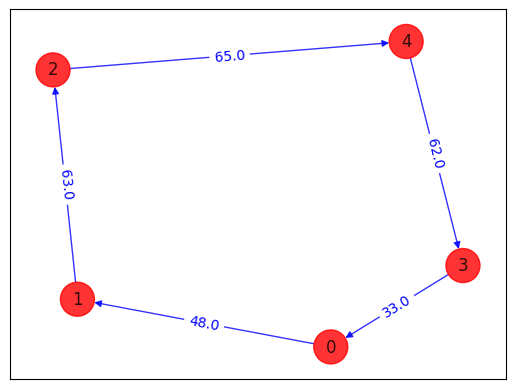

In [7]:
draw_tsp_solution(tsp.graph, best_order, colors, pos)

#### Résolution quantique par correspondance avec le problème d'Ising

On souhaite désormais transformer le TSP en un problème **Ising** ou **QUBO** (Quadratic Unconstrained Binary Optimization). Le concept est le suivant : on encode une variable binaire $x_{i,p}$ qui vaut $1$ si la ville $i$ est visitée à la position $p$ du cycle, et $0$ sinon. On a donc $n^2$ varibales binaires et chaque chemin complet est une matrice contenant exactement un $1$ dans chaque ligne et chaque colonne.

In [8]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_4 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_4
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_4 + 85*x_0_0*x_4_1 + 85*x_0_0*x_4_4
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2 + 85*x_0_1*x_4_0 + 85*x_0_1*x_4_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 85*x_0_2*x_4_1 + 85*x_0_2*x_4_3
  + 48*x_0_3*x_1_2 + 48*x_0_3*x_1_4 + 91*x_0_3*x_2_2 + 91*x_0_3*x_2_4
  + 33*x_0_3*x_3_2 + 33*x_0_3*x_3_4 + 85*x_0_3*x_4_2 + 85*x_0_3*x_4_4
  + 48*x_0_4*x_1_0 + 48*x_0_4*x_1_3 + 91*x_0_4*x_2_0 + 91*x_0_4*x_2_3
  + 33*x_0_4*x_3_0 + 33*x_0_4*x_3_3 + 85*x_0_4*x_4_0 + 85*x_0_4*x_4_3
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_4 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_4
  + 93*x_1_0*x_4_1 + 93*x_1_0*x_4_4 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2 + 93*x_1_1*x_4_0 + 93*x_1_1*x_4_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*

Les contraintes d'assignation linéaires que l'on voit apparaître permettent de garantir que chaque ville n'apparait q'une seule fois dans la solution et que chaque position ne contient qu'une seule ville. Elles permettent de garantir que les conditions d'énonciation du problème sont bien vérifiées et que la solution est un permutation.

La fonction **minimize** est la fonction de coût que va chercher à minimiser l'algorithme. Elle se décompose en somme de coût de trajet entre deux positions succesives de la forme  : $w_{ij} * x_{i,p} * x_{j,p+1}$

Par exemple : $ 48 * x_{0,0} * x_{1,1} $ correspond au coût pour aller de la ville 0 en position 0, à la ville 1 en position 1.

La résolution de la fonction **minimize** donne le coût et l'ordre du cycle hamiltoninen recherché.

In [9]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")

print(str(qubitOp))



Problem name: TSP

Minimize
  14062*x_0_0^2 + 14062*x_0_0*x_0_1 + 14062*x_0_0*x_0_2 + 14062*x_0_0*x_0_3
  + 14062*x_0_0*x_0_4 + 14062*x_0_0*x_1_0 + 48*x_0_0*x_1_1 + 48*x_0_0*x_1_4
  + 14062*x_0_0*x_2_0 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_4 + 14062*x_0_0*x_3_0
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_4 + 14062*x_0_0*x_4_0 + 85*x_0_0*x_4_1
  + 85*x_0_0*x_4_4 + 14062*x_0_1^2 + 14062*x_0_1*x_0_2 + 14062*x_0_1*x_0_3
  + 14062*x_0_1*x_0_4 + 48*x_0_1*x_1_0 + 14062*x_0_1*x_1_1 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 14062*x_0_1*x_2_1 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0
  + 14062*x_0_1*x_3_1 + 33*x_0_1*x_3_2 + 85*x_0_1*x_4_0 + 14062*x_0_1*x_4_1
  + 85*x_0_1*x_4_2 + 14062*x_0_2^2 + 14062*x_0_2*x_0_3 + 14062*x_0_2*x_0_4
  + 48*x_0_2*x_1_1 + 14062*x_0_2*x_1_2 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1
  + 14062*x_0_2*x_2_2 + 91*x_0_2*x_2_3 + 33*x_0_2*x_3_1 + 14062*x_0_2*x_3_2
  + 33*x_0_2*x_3_3 + 85*x_0_2*x_4_1 + 14062*x_0_2*x_4_2 + 85*x_0_2*x_4_3
  + 14062*x_0_3^2 + 14062*x_0_3*x_0_4 + 48*x_0_3*x_1_2 + 14062*x_0_3*x_1_3

Pour passer d'un programme quadratique avec contraintes à un problème QUBO, les contraintes linéaires précédentes doivent être encodées sous forme de pénalités.  
Par exemple :  $x_{0,0} + x_{0,1}+x_{0,2} =1 \ \textrm{  devient  } \ λ(x_{0,0}+x_{0,1}+x_{0,2}−1)^2$

On obtient alors une unique matrice $Q$ combinant coût et pénalité, de sorte que le problème QUBO s'exprime comme une minimisation de $x^T Qx$

Enfin, le QUBO est transformé en un Hamiltonien Ising. Pour cela, chaque variable $x_{i} ∈ \{0,1\}$ est transformée en spins $𝑧_{𝑖} ∈\{−1,+1\}$.

On obtient un hamiltonien exprimé comme une multiplication de coefficients et d'opérateurs de Pauli.

In [10]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 271.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_0_4=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_1_4=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_2_4=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, x_3_4=0.0, x_4_0=0.0, x_4_1=0.0, x_4_2=0.0, x_4_3=0.0, x_4_4=1.0
status: SUCCESS


energy: -247571.5
tsp objective: 271.0
feasible: True
solution: [3, 0, 1, 2, 4]
solution objective: 271.0


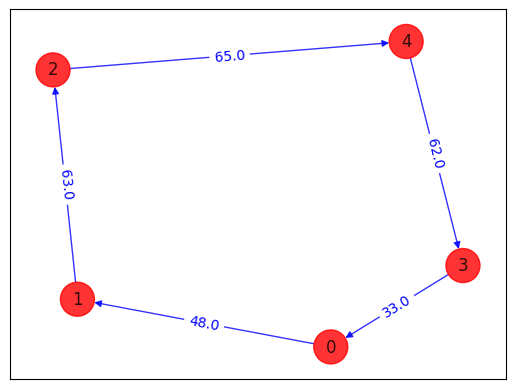

In [11]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

Ce solveur (classique) nous fournit la meilleure solution possible pour notre instance du TSP. Il calcule le spectre de l'Hamiltonien Ising, et identifie son état de plus basse énergie. C'est cet état qui correspond à la solution otpimale du QUBO et donc du TSP. On peut alors vérifier la solution et afficher le cycle correspondant pour mieux la visualiser.

Avec cette méthode, nous manipulons un modèle quantique (Ising) qui est exécuté sur un solveur classique (NumPy). Ce n'est qu'une émulation du résultat que donnerai un système quantique, calculé par l'intermédiraire de méthodes d'algèbre classiques (création de matrice, calcul de valeurs propres ...). Ce calcul n'introduit donc ni erreur de porte, ni bruit de mesure.

Cette résolution nous permet ainsi de vérifier la validité du modèle QUBO/Ising, en trouvant une solution optimale exacte. 

#### Exécution sur un ordinateur quantique par simulation 

In [ ]:
# Fixation des seeds pour garantir la reproductibilité
algorithm_globals.random_seed = 123
seed = 10598

In [ ]:
# SPSA : Simultaneous Perturbation Stochastic Approximation
# Algorithme classique d'optimisation

optimizer = SPSA(maxiter=1000) 


# Circuit quantique paramètré avec rotation et porte d'intrication
ry = n_local(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")

# VQE : Variational Quantum Eigensolver
vqe = SamplingVQE(sampler=StatevectorSampler(seed=123), ansatz=ry, optimizer=optimizer)
result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate) # Mesure de l’état quantique
print("feasible:", qubo.is_feasible(x)) # Vérifie que les contraintes TSP sont respectées
z = tsp.interpret(x) # Convertit le résultat quantique en suite de sommet (villes)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix)) # Calcule la longueur du tour donné par la solution 
draw_tsp_solution(tsp.graph, z, colors, pos)

Cette implémentation est un algorithme hybride quantique-classique utilisant un solveur variationnel quantique (VQE) qui est ici simulé de manière classique. On observe une absence d’avantage réel de performance par rapport à la méthode brute détaillée précédemment. Il est logique que cette méthode soit plus lente que la version classique pour un problème comme le TSP, dans les conditions actuelles de l’informatique quantique. 

En effet, on assiste à une surcharge de conversion et pénalités. Le TSP passe par d'importantes phases de conversion. Il est d’abord formulé comme un programme quadratique avec des contraintes, puis converti en QUBO, puis en Hamiltonien Ising. Ces transformations ajoutent à la complexité de l'algorithme. De plus, le solveur quantique doit explorer un espace de solutions très large, ce qui rend la recherche extrêmement lourde.

Enfin, comme expliqué plus en détail dans notre rapport, les dispositifs quantiques actuels sont encore très limités. Les qubits disponibles sont peu nombreux, sujets au bruit, et aux erreurs. D’après la documentation même de Qiskit : "Currently, quantum computers do not outperform classical computers for combinatorial optimization because of noise."

Ainsi, pour des instances modestes du TSP, les solveurs classiques sont beaucoup plus optimisés.

#### Comparaison des temps d'éxécution classique et quantique

In [12]:
clas_time = []
quant_time = []

for n in [3,4,5] :
    num_qubits = n**2
    tsp = Tsp.create_random_instance(n, seed=123)
    adj_matrix = nx.to_numpy_array(tsp.graph)
        
    start_time = time.time()
    best_distance, best_order = brute_force_tsp(adj_matrix, n)
    clas_time.append(time.time() - start_time)
    
    start_time = time.time()
    qp = tsp.to_quadratic_program()
    qp2qubo = QuadraticProgramToQubo()
    qubo = qp2qubo.convert(qp)
    qubitOp, offset = qubo.to_ising()
    exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = exact.solve(qubo)
    quant_time.append(time.time() - start_time)

order = (0, 1, 2) Distance = 202.0
order = (0, 1, 2, 3) Distance = 236.0
order = (0, 1, 2, 3, 4) Distance = 350.0
order = (0, 1, 2, 4, 3) Distance = 271.0


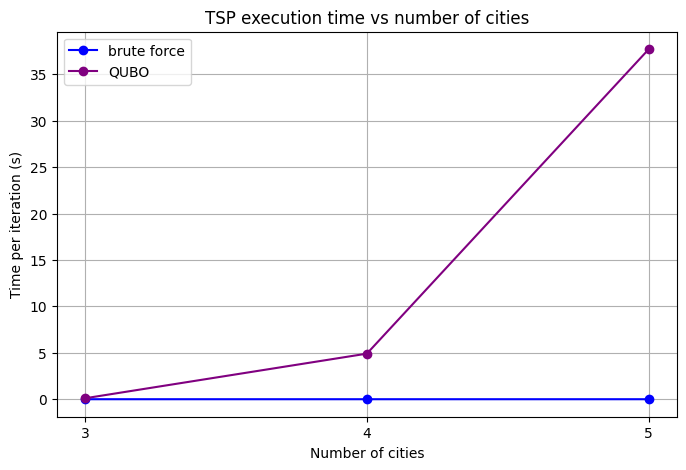

In [18]:
import matplotlib.pyplot as plt 
import math
plt.figure(figsize=(8, 5))
x = [3,4,5]
plt.plot(x, clas_time, marker='o', label='brute force', color ="blue")
plt.plot(x, quant_time, marker='o', label="QUBO", color = "purple")
new_list = range(math.floor(min(x)), math.ceil(max(x))+1)
plt.xticks(new_list)
plt.xlabel('Number of cities')
plt.ylabel('Time per iteration (s)')
plt.legend()
plt.title('TSP execution time vs number of cities')
plt.grid(True)